# DETECCIÓN DE OPERADORES INEFICACES EN EMPRESA DE TELEFONÍA VIRTUAL "CALL ME MAYBE"

## INICIALIZACIÓN 

In [225]:
# Cargar todas las librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats as st

Empezamos importando todas las librerías necesarias para ejecutar el proyecto.

## CARGA DE DATOS

In [226]:
url_1 = 'https://raw.githubusercontent.com/doalpinc98/virtual_telephone_company/main/telecom_clients_us.csv'
url_2 = 'https://raw.githubusercontent.com/doalpinc98/virtual_telephone_company/main/telecom_dataset_us.csv'
client = pd.read_csv(url_1, sep=',')
data = pd.read_csv(url_2, sep=',')


Se carga los base de datos de los clientes y de las llamadas entrantes y salientes respecto a cada agente del call center.

## EXPLORACIÓN Y PROCESAMIENTO DE DATOS


In [227]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


El conjunto de datos telecom_clients_us.csv tiene las siguientes columnas:<br>
•	user_id: ID de usuario/a<br>
•	tariff_plan: tarifa actual de la clientela<br>
•	date_start: fecha de registro de la clientela<br>


In [228]:
client.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [229]:
client.duplicated().sum()

0

 Se observa que no existen datos duplicados en la base de clientes.

In [230]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


El dataset comprimido telecom_dataset_us.csv contiene las siguientes columnas: <br>
•	user_id: ID de la cuenta de cliente<br>
•	date: fecha en la que se recuperaron las estadísticas<br>
•	direction: "dirección" de llamada (out para saliente, in para entrante)<br>
•	internal: si la llamada fue interna (entre los operadores de un cliente o clienta)<br>
•	operator_id: identificador del operador<br>
•	is_missed_call: si fue una llamada perdida<br>
•	calls_count: número de llamadas<br>
•	call_duration: duración de la llamada (sin incluir el tiempo de espera)<br>
•	total_call_duration: duración de la llamada (incluido el tiempo de espera)<br>


In [231]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [232]:
data.duplicated().sum()

4900

Se observa que existen datos duplicados en la base de datos de las llamadas inbound/outbound.

In [233]:
data.drop_duplicates(inplace = True)

Se procedió a eliminar los datos duplicados.

In [234]:
data.duplicated().sum()

0

Se comprueba que no existen más datos duplicados.

In [235]:
100*data.isna().sum()/data.shape[0]

user_id                 0.000000
date                    0.000000
direction               0.000000
internal                0.224481
operator_id            15.215705
is_missed_call          0.000000
calls_count             0.000000
call_duration           0.000000
total_call_duration     0.000000
dtype: float64

Se observa que existe un 15% de datos de operarios sin su identificación. Se procede a eliminar los datos de los operadores sin información, dado que es necesario para el análisis posterior. 

In [236]:
data = data.dropna()

In [237]:
100*data.isna().sum()/data.shape[0]

user_id                0.0
date                   0.0
direction              0.0
internal               0.0
operator_id            0.0
is_missed_call         0.0
calls_count            0.0
call_duration          0.0
total_call_duration    0.0
dtype: float64

In [238]:
data['user_id'] = data['user_id'].astype('str')
data['operator_id'] = data['operator_id'].astype('str')

Se procedió a cambiar el tipo de datos a cadena para las variables de 'user_id' y 'operador_id', dado que con dichos números no se pretende realizar un cálculo, sino que sirven como huella digital de cada persona. 

## ANÁLISIS DE DATOS

A continuación se añade una columna con la resta entre el tiempo total de la llamada y la duración de la llamada para obtener el tiempo de espera.

In [239]:
data['waiting_time'] = data['total_call_duration'] - data['call_duration']

In [240]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,8
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29,26


In [241]:
data['date'].min()

'2019-08-02 00:00:00+03:00'

In [242]:
data['date'].max()

'2019-11-28 00:00:00+03:00'

Adicionalmente podemos observar que la información analizada corresponde a un corto periodo de tiempo, que comprende desde el 2 de agosto al 28 de noviembre del 2019. 

In [243]:
len(data['operator_id'].unique())

1092

Se observa que existen 1092 agentes de call center durante el periodo de estudio.

In [244]:
len(data['user_id'].unique())

290

In [245]:
len(client['user_id'].unique())

732

Se observa que existen 290 clientes que se contactan o son contactados por el call center, de un total de 732 clientes. 

In [246]:
data.groupby('is_missed_call')['user_id'].count()

is_missed_call
False    27382
True     14109
Name: user_id, dtype: int64

14109 llamadas no fueron atendidas.

In [247]:
data_pivot = data.pivot_table(
    index=['operator_id'],
    columns='is_missed_call',
    values='calls_count',
    aggfunc='sum',
)

In [248]:
data_pivot 

is_missed_call,False,True
operator_id,,
879896.0,679.0,251.0
879898.0,4952.0,2360.0
880020.0,23.0,22.0
880022.0,92.0,105.0
880026.0,1584.0,648.0
...,...,...
972410.0,40.0,37.0
972412.0,36.0,25.0
972460.0,23.0,28.0


In [249]:
data.describe()

,calls_count,call_duration,total_call_duration,waiting_time
count,41491.000000,41491.000000,41491.000000,41491.000000
mean,16.921381,1010.940011,1323.153238,312.213227
std,59.786187,4066.666485,4788.953155,1176.102940
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,67.000000,19.000000
50%,4.000000,106.000000,289.000000,60.000000
75%,14.000000,772.000000,1107.000000,219.000000
max,4817.000000,144395.000000,166155.000000,46474.000000


A partir de la tabla mostrada, se observa un promedio de 312 segundos por llamada, con un máximo de 46474 segundos por llamada, lo cual se traduce en 12,91 horas en espera. Este valor se considera como un dato aberrante. Se tratará los datos aberrantes posteriormente.

### DISTRIBUCIÓN DE LLAMADAS

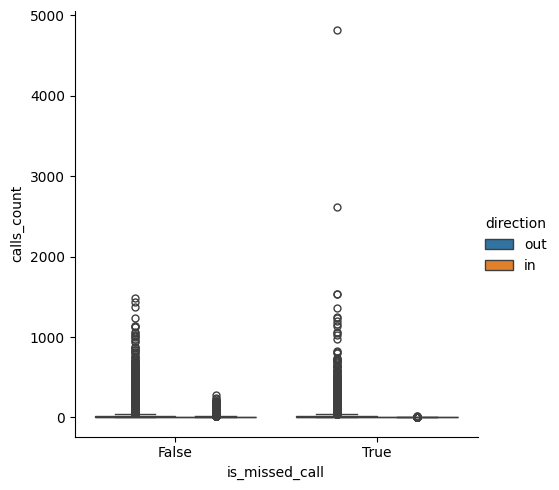

In [250]:
sns.catplot(data= data, x="is_missed_call", y="calls_count", kind="box", hue = 'direction')

### DISTRIBUCIÓN DE TIEMPOS DE ESPERA

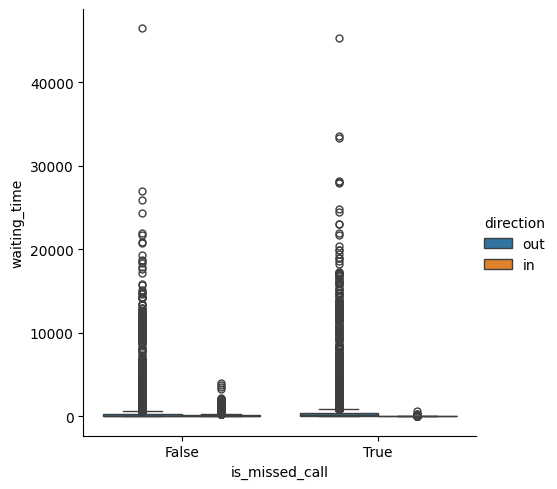

In [251]:
sns.catplot(data= data, x="is_missed_call", y="waiting_time", kind="box", hue = 'direction')

### TRANSFORMACIÓN DE DATOS ABERRANTES

A continuación, se tratará los datos aberrantes de los tiempos de espera. 

In [252]:
def fix_waiting_time(row):

    if row['waiting_time']>312:
        return 312
    else:
        return row['waiting_time']

In [253]:
data['waiting_time'] = data.apply(fix_waiting_time, axis = 1)

In [254]:
data.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,8


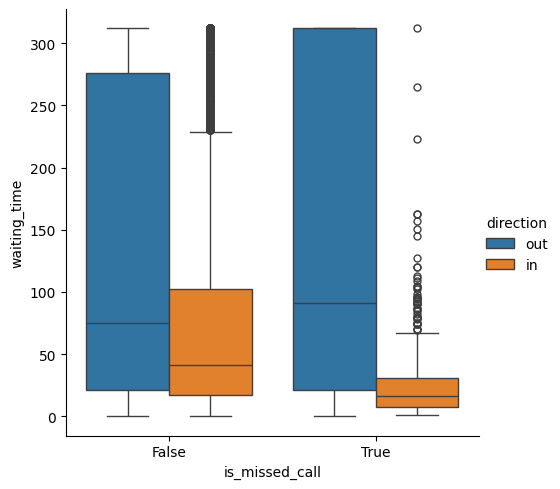

In [255]:
sns.catplot(data= data, x="is_missed_call", y="waiting_time", kind="box", hue = 'direction')

In [256]:
data_waiting_time_max = data.groupby('direction')['waiting_time'].max()

In [257]:
data_waiting_time_max

direction
in     312
out    312
Name: waiting_time, dtype: int64

### TOP OPERADORES EN CALL CENTER QUE PIERDEN LLAMADAS ENTRANTES

A continuación se detectará aquellos agentes de call center que perdieron la mayor cantidad de llamadas entrantes.

In [258]:
inbound_loss = data[(data['direction']=='in') & (data['is_missed_call'] == True)]

In [259]:
#TOP OPERADORES QUE NO ATIENDEN LLAMADAS
new_data_call_center = (inbound_loss.pivot_table(index = 'operator_id',
                                          values = 'calls_count',
                                          aggfunc = 'sum')
                    .sort_values('calls_count', ascending = False)
                    .head(30))
new_data_call_center

new_df = new_data_call_center

new_df.columns.name = None

new_df.reset_index()

print(new_df)

             calls_count
operator_id             
913942.0              52
940588.0              30
944226.0              30
885890.0              26
944216.0              24
937956.0              24
951508.0              21
885876.0              20
944220.0              18
944222.0              17
940630.0              17
940622.0              16
948286.0              15
944218.0              15
905862.0              15
908960.0              14
913938.0              14
931458.0              12
919554.0              11
901880.0              11
921818.0              10
940658.0              10
893804.0              10
925922.0              10
940652.0               9
919204.0               9
919206.0               9
905104.0               8
952948.0               8
937958.0               8


### TOP OPERADORES QUE HACEN ESPERAR MUCHO TIEMPO A LOS CLIENTES EN LLAMADAS ENTRANTES

A continuación se detectará aquellos agentes de call center que recibieron una llamada, sin embargo hubo largo tiempo de espera por parte del usuario. 

In [260]:
inbound = data[(data['direction']=='in') & (data['is_missed_call'] == False)]

In [261]:
#
new_data_call_center_2 = (inbound.pivot_table(index = 'operator_id',
                                          values = 'waiting_time',
                                          aggfunc = 'mean')
                    .sort_values('waiting_time', ascending = False)
                    .head(30))
new_data_call_center_2

new_df2 = new_data_call_center_2

new_df2.columns.name = None

new_df2.reset_index()

print(new_df2)

             waiting_time
operator_id              
919206.0       312.000000
919204.0       312.000000
919794.0       312.000000
906406.0       299.309524
919554.0       297.609375
919552.0       293.460317
921318.0       291.688889
919166.0       281.800000
906404.0       280.000000
919164.0       279.666667
931458.0       278.400000
913938.0       274.250000
919790.0       269.966102
958460.0       265.076923
913942.0       264.684211
919792.0       251.392857
939762.0       248.756098
938414.0       246.285714
882688.0       246.000000
921818.0       240.633333
971102.0       238.500000
954750.0       234.117647
951508.0       217.739130
944220.0       214.918919
908958.0       214.700000
952948.0       214.360000
944218.0       208.648649
969272.0       207.857143
906408.0       204.333333
882690.0       203.150000


Para lograr detectar quienes son operadores ineficaces, se procede a encontrar aquellos agentes que pierden la mayor cantidad de llamadas entrantes y que tienen largos tiempos de espera para el cliente en las llamadas entrantes. 

In [262]:
both = new_df.merge(new_df2, on='operator_id')
print(both) 

             calls_count  waiting_time
operator_id                           
913942.0              52    264.684211
951508.0              21    217.739130
944220.0              18    214.918919
944218.0              15    208.648649
913938.0              14    274.250000
931458.0              12    278.400000
919554.0              11    297.609375
921818.0              10    240.633333
919204.0               9    312.000000
919206.0               9    312.000000
952948.0               8    214.360000


Se observa en la tabla los operadores más ineficaces en el call center. 

## CONCLUSIÓN

En conclusión, se logra limpiar la base de datos, eliminar datos duplicados, gestionar los valores nulos y los datos aberrantes. Se logró detectar aquellas personas que tienen un bajo desempeño dentro de sus funciones como agentes de call center. 